In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import os

# Get Data from GitHub

In [2]:
! python get_data.py

In [3]:
confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recover = pd.read_csv('data/time_series_19-covid-Recovered.csv')

Data problem in the 3/11/20 - I will remove that day

In [4]:
confirmed = confirmed[confirmed.columns[confirmed.columns != '3/11/20']]

In [5]:
day = datetime.today() - timedelta(days=1)

In [6]:
datastr = day.strftime('%m/%d')[1:] + '/20'

# Data transformation

In [7]:
confirmed_by_country = confirmed[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_confirmed'})

In [8]:
deaths_by_country = deaths[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_deaths'})

In [9]:
recover_by_country = recover[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_recover'})

In [10]:
global_df = confirmed_by_country.merge(deaths_by_country, how='left', left_index=True, right_index=True).\
merge(recover_by_country, how='left', left_index=True, right_index=True)

In [11]:
confirmed_country_day = confirmed.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [12]:
recover_country_day = recover.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [13]:
deaths_country_day = deaths.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [14]:
ndays_since_first_confirmed = confirmed_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [15]:
ndays_since_first10_confirmed = confirmed_country_day.apply(lambda x: (x >= 10).sum(), axis=1)

In [16]:
ndays_since_first_death = deaths_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [17]:
ndays_since_first_recovery = recover_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [18]:
global_df = global_df.merge(ndays_since_first_confirmed.rename('days'), right_index=True, left_index=True)

In [19]:
global_df = global_df.merge(ndays_since_first_death.rename('ndays_since_first_death'), right_index=True, left_index=True)

In [20]:
global_df = global_df.merge(ndays_since_first_recovery.rename('ndays_since_first_recover'), right_index=True, left_index=True)

In [21]:
global_df = global_df.merge(ndays_since_first10_confirmed.rename('ndays_since_first10_confirmed'), right_index=True, left_index=True)

In [22]:
global_df['unk_state'] = global_df.n_confirmed-global_df.n_deaths-global_df.n_recover

In [23]:
print (global_df)

n_confirmed  n_deaths  n_recover  days  \
Country/Region                                                
Afghanistan                   22         0          1    22   
Albania                       55         1          0     8   
Algeria                       60         4         12    21   
Andorra                       39         0          1    15   
Antigua and Barbuda            1         0          0     5   
...                          ...       ...        ...   ...   
United Kingdom              1960        56         53    46   
Uruguay                       29         0          0     4   
Uzbekistan                    10         0          0     3   
Venezuela                     33         0          0     4   
Vietnam                       66         0         16    54   

                     ndays_since_first_death  ndays_since_first_recover  \
Country/Region                                                            
Afghanistan                                0       

# Analysis

In [24]:
print(f"{global_df.shape[0]} coutries with confirmed cases so far, {global_df.n_confirmed.sum()} confirmed cases, \
{global_df.n_deaths.sum()} deaths and {global_df.n_recover.sum()} recovers.")

152 coutries with confirmed cases so far, 197146 confirmed cases, 7905 deaths and 80840 recovers.


In [25]:
global_df.loc[['Italy', 'China', 'Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'United Kingdom'], 
              ['n_confirmed', 'days', 'ndays_since_first10_confirmed']]

,n_confirmed,days,ndays_since_first10_confirmed
Country/Region,,,
Italy,31506,46,25
China,81058,55,55
Spain,11748,45,20
France,7699,53,38
Netherlands,1708,19,16
Portugal,448,15,11
Germany,9257,50,44
United Kingdom,1960,46,22


In [26]:
today = (datetime.today()-timedelta(days=1)).strftime('%d-%m-%Y')

In [27]:
colors = cm.get_cmap('tab20').colors

In [28]:
country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]

pt_days = len(country_data)

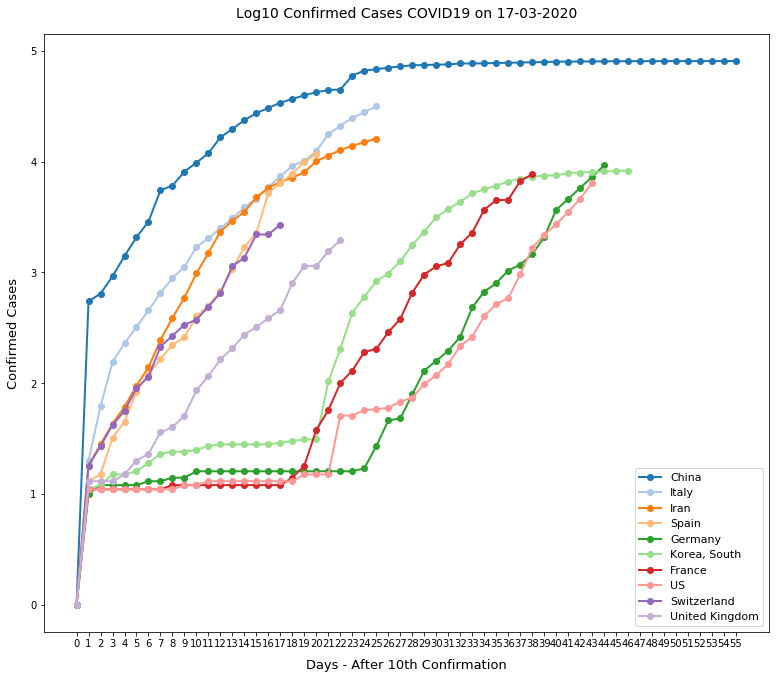

In [29]:
countries = confirmed_by_country['n_confirmed'].sort_values(ascending=False)[:10].index
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = confirmed_country_day.loc[country]
    country_data = country_data[country_data>=10]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2, marker='o')

_ = plt.xticks(ticks=list(range(0,max_days+1)))

_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title(f'Log10 Confirmed Cases COVID19 on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 10th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmed Cases', fontdict={'fontsize':13}, labelpad=10.0)

plt.savefig('data/log10_nconfirmed_top10.png')

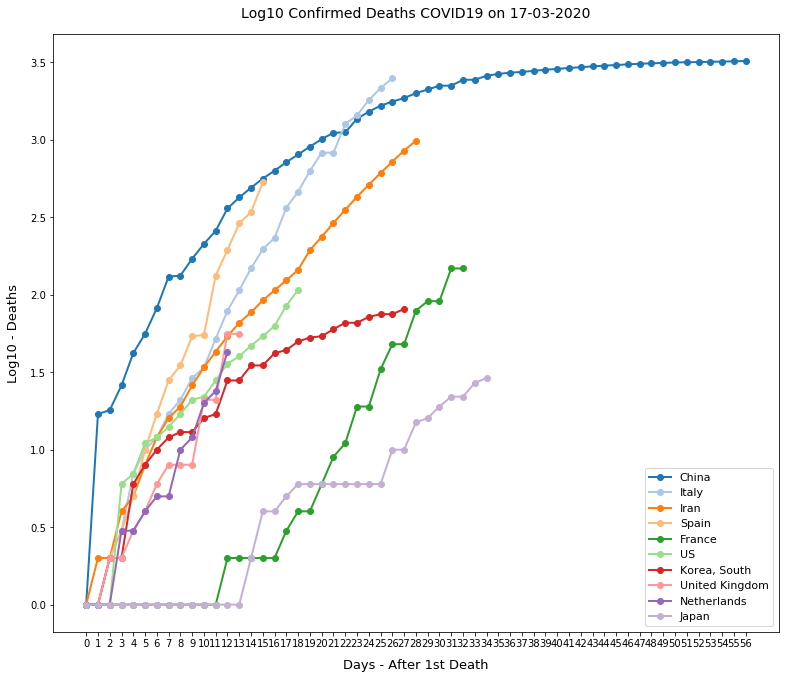

In [30]:
countries = deaths_by_country['n_deaths'].sort_values(ascending=False)[:10].index.values
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = deaths_country_day.loc[country]
    country_data = country_data[country_data>=1]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2, marker='o')

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title(f'Log10 Confirmed Deaths COVID19 on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 1st Death', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Deaths', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/log10_ndeaths_top10.png')

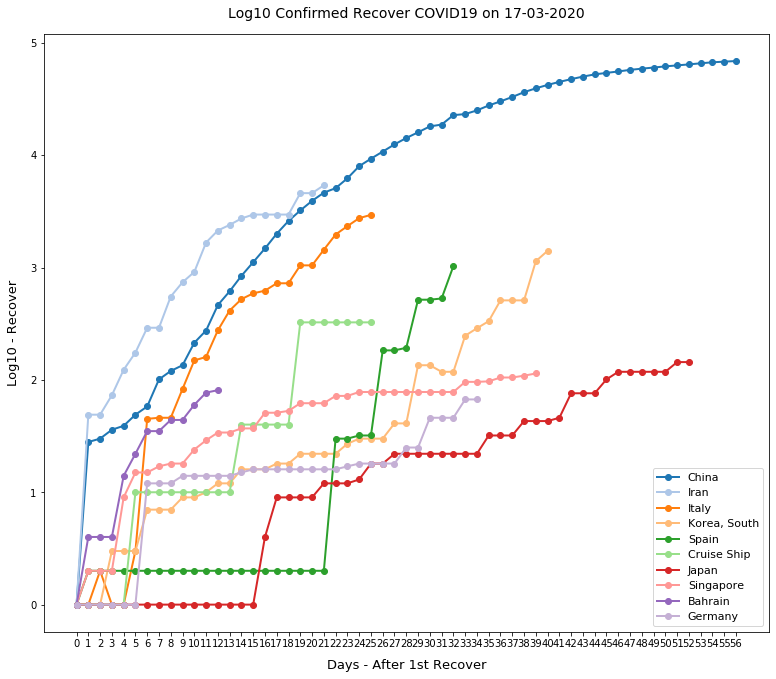

In [31]:
countries = recover_by_country['n_recover'].sort_values(ascending=False)[:10].index.values
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = recover_country_day.loc[country]
    country_data = country_data[country_data>=1]

    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=colors[i], linewidth=2, marker='o')

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title(f'Log10 Confirmed Recover COVID19 on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 1st Recover', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Recover', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/log10_nrecover_top10.png')

In [32]:
global_df['deaths_ratio'] = (global_df.loc[:, 'n_deaths'] / global_df.loc[:, 'n_confirmed'])

In [33]:
global_df['recover_ratio'] = (global_df.loc[:, 'n_recover'] / global_df.loc[:, 'n_confirmed'])

Country/Region
Italy             0.079445
Iran              0.061105
Spain             0.045369
China             0.039848
United Kingdom    0.028571
France            0.019223
US                0.016820
Korea, South      0.009736
Name: deaths_ratio, dtype: float64


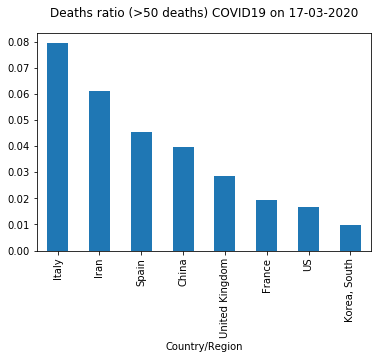

In [34]:
deaths_ratio = global_df.loc[:, ['n_deaths', 'n_recover', 'n_confirmed', 'deaths_ratio','recover_ratio']].sort_values(by='deaths_ratio', ascending=False)

deaths_ratio = deaths_ratio[deaths_ratio['n_deaths'] > 50]['deaths_ratio'][:10]

print (deaths_ratio)
ax = deaths_ratio.plot.bar()
fig = ax.get_figure()
_ = plt.title(f'Deaths ratio (>50 deaths) COVID19 on {today}', fontdict={'fontsize':12}, pad=16.0)
fig.savefig('data/ratio_50deaths.png')

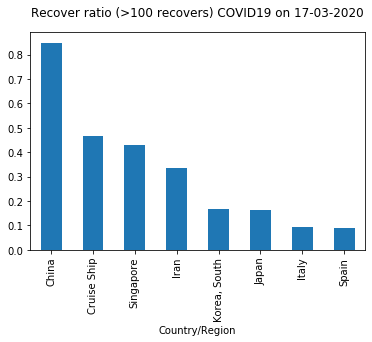

In [35]:
recover_ratio = global_df.loc[:, ['n_deaths', 'n_recover', 'n_confirmed', 'deaths_ratio','recover_ratio']].sort_values(by='recover_ratio', ascending=False)

recover_ratio = recover_ratio[recover_ratio['n_recover'] > 100]['recover_ratio'][:10]

ax = recover_ratio.plot.bar()
fig = ax.get_figure()
_ = plt.title(f'Recover ratio (>100 recovers) COVID19 on {today}', fontdict={'fontsize':12}, pad=16.0)
fig.savefig('data/ratio_100recovers.png')

# Models

In [36]:
def logistic(x, a, k):
    return 1 / (1 + np.exp(-k * (x - a)))

In [37]:
def exponential_portugal(x,z,k,c):
    return z*np.exp(x*k)*c

In [38]:
def exponential(x,z,k,c):
    return z*np.exp(x*k)*c

In [39]:
def quadratic(x,z,k):
    return z**(x*k)

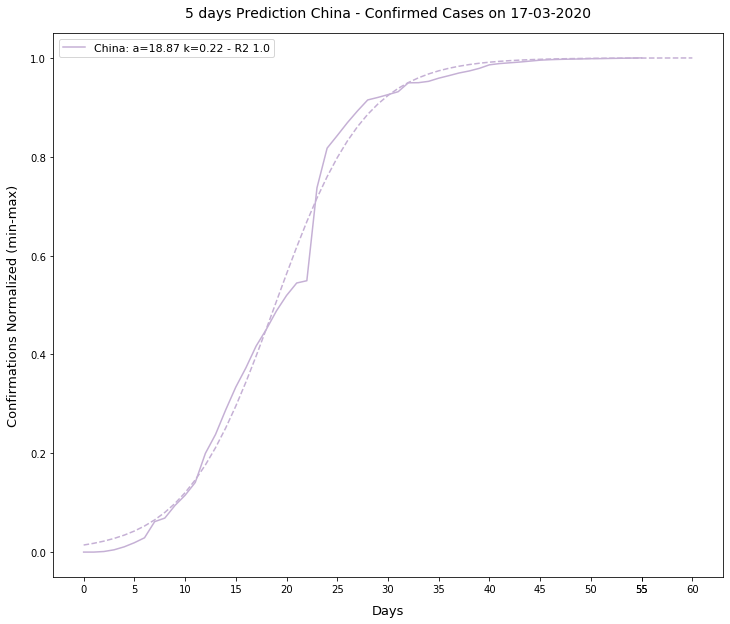

In [40]:
ndays_prev = 5
plt.figure(figsize=(12,10))

country_y = confirmed_country_day.loc['China']
country_y = (country_y - country_y.min()) / (country_y.max() - country_y.min())

country_y = np.concatenate((np.array([0]),country_y))
xdata_real = list(range(len(country_y)))

popt, pcov = curve_fit(logistic, xdata_real, country_y)
xdata_all = xdata_real + [i for i in range(xdata_real[-1], xdata_real[-1]+ndays_prev+1)]

prevs_to_plot = logistic(np.array(xdata_all), *popt)
predicted_func = logistic(np.array(xdata_real), *popt)
coefficient_of_dermination = r2_score(country_y,  predicted_func)


plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=colors[i])
plt.plot(xdata_real, country_y, color=colors[i], \
         label=f"China: a={round(popt[0], 2)} k={round(popt[1], 2)} - R2 {round(coefficient_of_dermination,2)}")

_ = plt.xticks(ticks=[x for x in xdata_all if x%5 == 0])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'5 days Prediction China - Confirmed Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations Normalized (min-max)', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modelchina.png')

QUADRATIC: United Kingdom


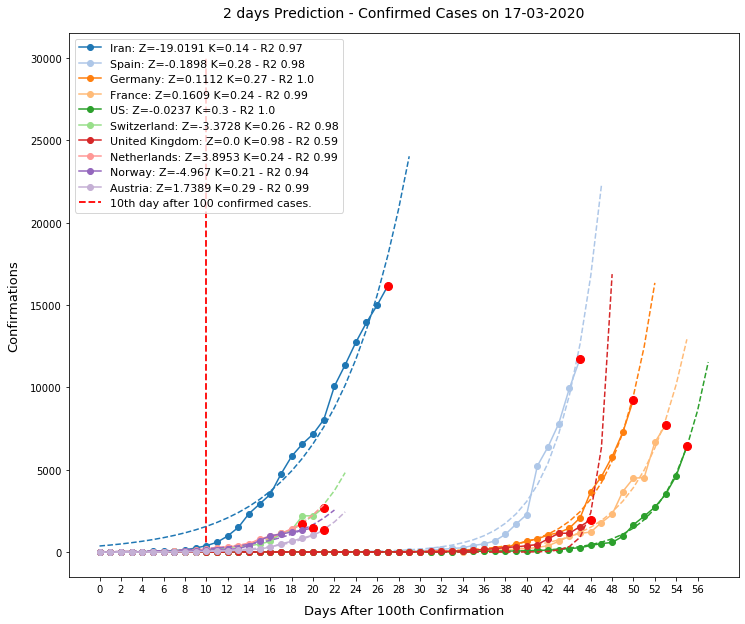

In [41]:
ndays_prev = 2
#colors = cm.get_cmap('Dark2').colors
plt.figure(figsize=(12,10))
confirmed_by_country_filtered = confirmed_by_country.drop(['China', 'Korea, South', 'Italy'])
countries = confirmed_by_country_filtered['n_confirmed'].sort_values(ascending=False)[:10].index.values
#countries = np.append(countries, 'Portugal')
maximum = 0

for i, country_name in enumerate(countries):
    country_y = confirmed_country_day.loc[country_name]
    country_y = country_y[country_y>=1]
    
    country_y = np.concatenate((np.array([0]),country_y))
    xdata_real = list(range(len(country_y)))
    
    popt, pcov = curve_fit(exponential, xdata_real, country_y, maxfev=100000)
    xdata_all = xdata_real + [i for i in range(xdata_real[-1]+1, xdata_real[-1]+ndays_prev+1)]
    
    if xdata_all[-1] > maximum:
        maximum = xdata_all[-1]
    
    prevs_to_plot = exponential(np.array(xdata_all), *popt)
    predicted_func = exponential(np.array(xdata_real), *popt)
    coefficient_of_dermination = r2_score(country_y,  predicted_func)
    if (coefficient_of_dermination < 0.8):
        print ("QUADRATIC:" , country_name)
        popt, pcov = curve_fit(exponential, xdata_real, country_y, maxfev=100000)
        xdata_all = xdata_real + [i for i in range(xdata_real[-1]+1, xdata_real[-1]+ndays_prev+1)]
        
        if xdata_all[-1] > maximum:
            maximum = xdata_all[-1]
        
        prevs_to_plot = exponential(np.array(xdata_all), *popt)
        predicted_func = exponential(np.array(xdata_real), *popt)
        coefficient_of_dermination = r2_score(country_y,  predicted_func)


    
    plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=colors[i])
    plt.plot(xdata_real, country_y, color=colors[i], marker='o', \
             label=f"{country_name}: Z={round(popt[0], 4)} K={round(popt[1], 2)} - R2 {round(coefficient_of_dermination,2)}")
    _ = plt.plot(len(country_y)-1, country_y[-1], 'ro', markersize=8)
        
_ = plt.vlines(x=10, ymin=0, ymax=30000, linestyles='dashed', colors='r', label=f'10th day after 100 confirmed cases.',
              linewidth=1.8)
_ = plt.xticks(ticks=[i for i in range(0, maximum+1) if i % 2 == 0])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'{ndays_prev} days Prediction - Confirmed Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 100th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/confirmed_top5.png')

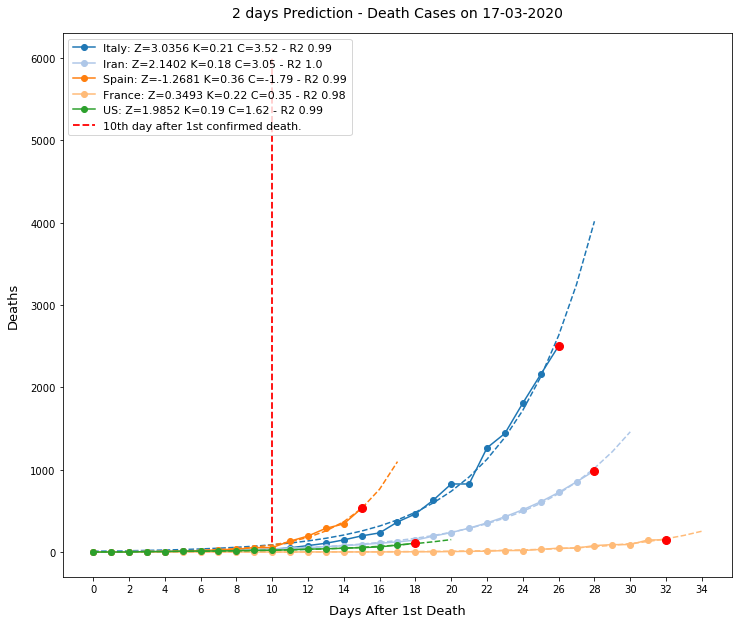

In [42]:
ndays_prev = 2
#colors = cm.get_cmap('Dark2').colors
plt.figure(figsize=(12,10))
deaths_by_country_filtered = deaths_by_country.drop(['China', 'Korea, South'])
countries = deaths_by_country_filtered['n_deaths'].sort_values(ascending=False)[:10].index
maximum = 0

for i, country_name in enumerate(countries):
    country_y = deaths_country_day.loc[country_name]
    country_y = country_y[country_y>=1]
    
    country_y = np.concatenate((np.array([0]),country_y))
    xdata_real = list(range(len(country_y)))
    
    popt, pcov = curve_fit(exponential, xdata_real, country_y, maxfev=5000)
    xdata_all = xdata_real + [i for i in range(xdata_real[-1]+1, xdata_real[-1]+ndays_prev+1)]
    
    if xdata_all[-1] > maximum:
        maximum = xdata_all[-1]
    
    prevs_to_plot = exponential(np.array(xdata_all), *popt)
    predicted_func = exponential(np.array(xdata_real), *popt)
    coefficient_of_dermination = r2_score(country_y,  predicted_func)

    
    plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=colors[i])
    plt.plot(xdata_real, country_y, color=colors[i], marker='o', \
             label=f"{country_name}: Z={round(popt[0], 4)} K={round(popt[1], 2)} C={round(popt[2], 2)} - R2 {round(coefficient_of_dermination,2)}")
    _ = plt.plot(len(country_y)-1, country_y[-1], 'ro', markersize=8)
        
_ = plt.vlines(x=10, ymin=0, ymax=6000, linestyles='dashed', colors='r', label=f'10th day after 1st confirmed death.',
              linewidth=1.8)
_ = plt.xticks(ticks=[i for i in range(0, maximum+1) if i % 2 == 0])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'{ndays_prev} days Prediction - Death Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 1st Death', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Deaths', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/deaths_top5.png')

We already have the resuls for Portugal for today:

https://covid19.min-saude.pt/ponto-de-situacao-atual-em-portugal/

In [43]:
cases_today = 642

In [44]:
today = datetime.today().strftime('%d-%m-%Y')
#today = (timedelta(days=-1)+datetime.today()).strftime('%d-%m-%Y')

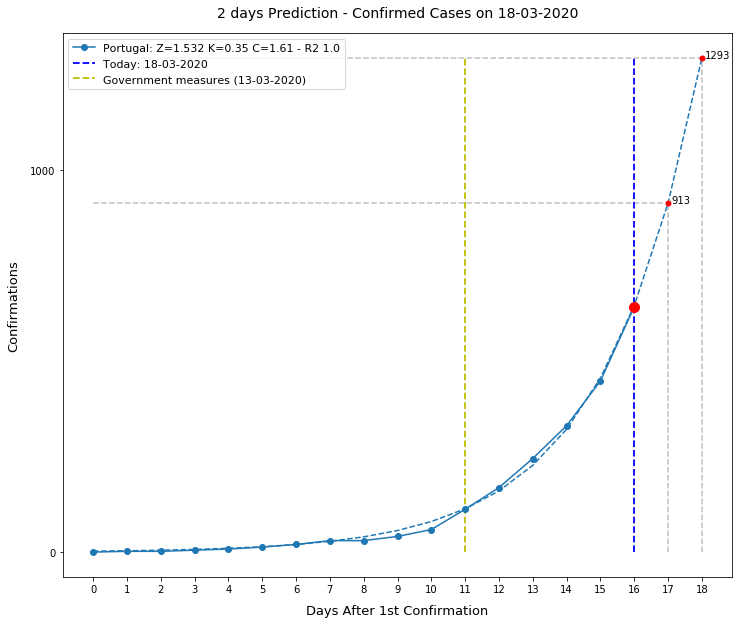

In [45]:
ndays_prev = 2
#colors = cm.get_cmap('Dark2').colors
plt.figure(figsize=(12,10))
countries = ['Portugal']
maximum = 0

for i, country_name in enumerate(countries):
    country_y = confirmed_country_day.loc[country_name]
    country_y = country_y[country_y>=1]
    
    country_y = np.concatenate((np.array([0]),country_y))
    country_y = np.concatenate((country_y, np.array([cases_today])))
    xdata_real = list(range(len(country_y)))
    
    popt, pcov = curve_fit(exponential_portugal, xdata_real, country_y)
    x_data_prev = [i for i in range(xdata_real[-1]+1, xdata_real[-1]+ndays_prev+1)]
    xdata_all = xdata_real + x_data_prev
    
    if xdata_all[-1] > maximum:
        maximum = xdata_all[-1]
    
    prevs_to_plot = exponential_portugal(np.array(xdata_all), *popt)
    predicted_func = exponential_portugal(np.array(xdata_real), *popt)
    coefficient_of_dermination = r2_score(country_y,  predicted_func)

    
    plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=colors[i])
    plt.plot(xdata_real, country_y, color=colors[i], marker='o', \
             label=f"{country_name}: Z={round(popt[0], 3)} K={round(popt[1], 2)} C={round(popt[2], 2)} - R2 {round(coefficient_of_dermination,2)}")
    _ = plt.plot(len(country_y)-1, country_y[-1], 'ro', markersize=10)
    
    yprevs = prevs_to_plot[(xdata_real[-1]+1):].astype(int).tolist()        
        
    for yprev, xday in zip(yprevs, x_data_prev):
        _ = plt.vlines(x=xday, ymin=0,  ymax=yprev, linestyles='dashed', colors='silver')
        _ = plt.hlines(y=yprev, xmin=0, xmax=xday, linestyles='dashed', colors='silver')
        _ = plt.text(xday+0.1, yprev, yprev, fontdict=None, withdash=False)
        _ = plt.plot(xday, yprev, 'ro', markersize=5)
    
_ = plt.vlines(x=xdata_real[-1], ymin=0, ymax=prevs_to_plot[-1], linestyles='dashed', colors='b', label=f'Today: {today}',linewidth=1.8) 

_ = plt.vlines(x=11, ymin=0, ymax=prevs_to_plot[-1], linestyles='dashed', colors='y', label=f'Government measures (13-03-2020)',
              linewidth=1.8)        
_ = plt.xticks(ticks=list(range(0, maximum+1)))
_ = plt.yticks(ticks=list(range(0, prevs_to_plot[-1].astype(int), 1000)))
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'{ndays_prev} days Prediction - Confirmed Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 1st Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modelportugal.png')

In [46]:
print (yprevs)

[913, 1293]


In [47]:
days_prev_date = [(timedelta(days=i) + datetime.now()).strftime('%d-%m-%Y') for i in range(1,ndays_prev+1)]

In [48]:
pd.DataFrame(yprevs, index=days_prev_date, columns=['Predicted Number of Confirmations'])

,Predicted Number of Confirmations
19-03-2020,913
20-03-2020,1293
